In [1]:
import rasterio
import numpy as np

path = r"C:/Users/joemo/Code/Repos/WRI-EBRD-Flood-Module/data_1/inuncoast_rcp8p5_wtsub_2080_rp0100_0.tif"

dataset = rasterio.open(path)



In [2]:
dataset.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333333333, 0.0, -180.0,
       0.0, -0.008333333333333333, 90.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [8]:
print(dataset.colorinterp[0])
print(dataset.width)
print(dataset.height)
print(dataset.dtypes)
print(dataset.crs)
# "EPSG 32612"?

ColorInterp.gray
43200
21600
('float32',)
EPSG:4326


In [2]:
band1 = dataset.read(1)

In [3]:
np.multiply(band1, 255.0 / 5.0 , out=band1, casting='unsafe')

array([[-509949., -509949., -509949., ..., -509949., -509949., -509949.],
       [-509949., -509949., -509949., ..., -509949., -509949., -509949.],
       [-509949., -509949., -509949., ..., -509949., -509949., -509949.],
       ...,
       [-509949., -509949., -509949., ..., -509949., -509949., -509949.],
       [-509949., -509949., -509949., ..., -509949., -509949., -509949.],
       [-509949., -509949., -509949., ..., -509949., -509949., -509949.]],
      dtype=float32)

In [4]:
mask = (band1 == -9999.0)
band1[mask] = 0.0
np.multiply(subset, 255.0 / 5.0 , out=subset, casting='unsafe')

In [6]:
np.array([255.0, 256.0, 300.0]).astype(np.uint8)

array([255,   0,  44], dtype=uint8)

In [1]:
from matplotlib import pyplot as plt
import os,json
import seaborn as sns
import numpy as np
import rasterio

file_name = 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000.tif'
#file_name = 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00100.tif'
#file_name = 'inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00010.tif'
directory = r"C:/Users/joemo/Code/Repos/WRI-EBRD-Flood-Module/data_1/"
colormap_type = 'fc3_'
path = os.path.join(directory, file_name)
max_intensity = 2.0 # 2 metres for inundation
    
print("Creating colour map")
orig_map = sns.color_palette("flare", as_cmap=True) #  plt.get_cmap("Reds") as altnerative
map = {}
map_for_json = {}
reds = np.zeros(256)
greens = np.zeros(256)
blues = np.zeros(256)
a = np.zeros(256)
for i in range(256):
    cols = (np.array(orig_map(i)) * 255).astype(np.uint8)
    map[i] = (cols[0], cols[1], cols[2], 200)
    map_for_json[i] = (int(cols[0]), int(cols[1]), int(cols[2]), 200)
    reds[i] = cols[0]
    greens[i] = cols[1]
    blues[i] = cols[2]
    a[i] = 200
map[0] = map[1] = ( 255, 255, 255, 0 )
map_for_json[0] = map_for_json[1] = ( 255, 255, 255, 0 ) # no data and zero are transparent
a[0] = a[1] = 0

with open(os.path.join(directory, 'colormap_' + file_name.split('.')[0] + '.json'), 'w') as f:
    colormap_info = json.dumps({ 'colormap': map_for_json,
        'nodata': { 'color_index':0 },
        'min': { 'data': 0.0, 'color_index':1 },
        'max': { 'data': 2.0, 'color_index':255 }
    })
    f.writelines(colormap_info)

with rasterio.open(path) as src:
    print("Reading")
    data = src.read(1)

    #subset = np.copy(data[5000:7000, 22000:24000])
    #profile['width'] = 1000
    #profile['height'] = 1000
    #plt.imshow(subset)

    print("Converting")    
    mask = (data < 0) # == -9999.0 is alternative
    mask2 = (data > max_intensity)
    
    np.multiply(data, 254.0 / max_intensity , out=data, casting='unsafe')
    np.add(data, 1.0, out=data, casting='unsafe') # np.clip seems a bit slow so we do not use

    # 0 is no data
    # 1 is zero
    # 255 is max intensity

    result = data.astype(np.uint8, casting='unsafe', copy=False)
    
    result[mask] = 0
    result[mask2] = 255

    profile = src.profile
    profile['dtype'] = 'uint8'
    profile['nodata'] = 0
    profile['count'] = 4

    path_out = os.path.join(directory, colormap_type + file_name) 
    
    print("Writing")
    with rasterio.open(path_out, 'w', **profile) as dst:
        #dst.colorinterp = [ ColorInterp.red, ColorInterp.green, ColorInterp.blue ]
        #dst.write(result, indexes=1)
        #dst.write_colormap(1, map)
        print("Writing R 1/4")
        dst.write(reds[result], 1)
        print("Writing G 2/4")
        dst.write(greens[result], 2)
        print("Writing B 3/4")
        dst.write(blues[result], 3)
        print("Writing A 4/4")
        dst.write(a[result], 4)

print("Done")

Creating colour map
Reading
Converting
Writing
Writing R 1/4
Writing G 2/4
Writing B 3/4
Writing A 4/4
Done


In [5]:
import numpy as np
a = np.array([0, 1, 2, 3, 4, 5])

b = np.array([[0, 0], [1, 3]])

print(a[b])


[[0 0]
 [1 3]]


In [12]:
#import seaborn as sns

#cmap = sns.color_palette("light:b", as_cmap=True)

map = plt.get_cmap("Reds")

map2 = {}
for i in range(256):
    cols = (np.array(map(i)) * 255).astype(np.uint8)
    #print(cols)
    map2[i] = (cols[0], cols[1], cols[3], 100)
#for i in range(0, 256):
#    map(i) * 255
print(map2)

{0: (255, 245, 255, 100), 1: (254, 244, 255, 100), 2: (254, 243, 255, 100), 3: (254, 243, 255, 100), 4: (254, 242, 255, 100), 5: (254, 241, 255, 100), 6: (254, 241, 255, 100), 7: (254, 240, 255, 100), 8: (254, 239, 255, 100), 9: (254, 239, 255, 100), 10: (254, 238, 255, 100), 11: (254, 237, 255, 100), 12: (254, 237, 255, 100), 13: (254, 236, 255, 100), 14: (254, 235, 255, 100), 15: (254, 235, 255, 100), 16: (254, 234, 255, 100), 17: (254, 233, 255, 100), 18: (254, 233, 255, 100), 19: (254, 232, 255, 100), 20: (254, 231, 255, 100), 21: (254, 231, 255, 100), 22: (254, 230, 255, 100), 23: (254, 229, 255, 100), 24: (254, 229, 255, 100), 25: (254, 228, 255, 100), 26: (254, 227, 255, 100), 27: (254, 227, 255, 100), 28: (254, 226, 255, 100), 29: (254, 225, 255, 100), 30: (254, 225, 255, 100), 31: (254, 224, 255, 100), 32: (253, 223, 255, 100), 33: (253, 222, 255, 100), 34: (253, 221, 255, 100), 35: (253, 220, 255, 100), 36: (253, 219, 255, 100), 37: (253, 218, 255, 100), 38: (253, 216, 255, 1

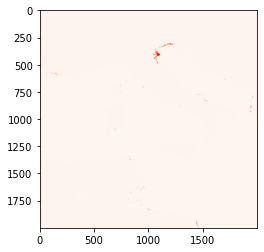

In [3]:
plt.imshow(result[5000:7000, 22000:24000], cmap='Reds')

In [2]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': -9999.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333333333333, 0.0, -180.0,
       0.0, -0.008333333333333333, 90.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [73]:
subset = np.copy(band1)

In [ ]:
sub

In [65]:
print(subset[330:340, 1130:1140])

[[2.1782455  2.7291863  3.010119   3.2976882  3.505496   3.1634252
  3.0282152  2.7190423  3.4099503  3.4220428 ]
 [2.427332   2.744678   3.112025   3.208474   3.2851362  2.456972
  0.9250968  0.4392444  1.729346   1.1126347 ]
 [2.6017573  3.250398   3.6256695  3.207587   3.0409782  0.7688029
  0.         0.         0.         0.        ]
 [4.032531   3.6250775  1.5904679  1.1194212  0.4602909  0.
  0.         0.         0.         0.        ]
 [0.21700811 0.         0.         1.1597266  0.         0.
  0.         0.         0.         0.        ]
 [1.8480079  2.399961   0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.  

In [66]:
print(subset[330:340, 1130:1140].astype(np.int8))

[[2 2 3 3 3 3 3 2 3 3]
 [2 2 3 3 3 2 0 0 1 1]
 [2 3 3 3 3 0 0 0 0 0]
 [4 3 1 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [49]:
map = plt.get_cmap("Blues")
#map(range(0,255))

map(255)

(0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0)

In [14]:
dataset.nodatavals

#band1[5000:5001, 20000:20001]

(-9999.0,)

In [34]:
dataset.colorinterp[0]

<ColorInterp.gray: 1>

In [ ]:
file = ""
with rasterio.open(file, 'w') as f:
    f.write(data.astype(np.int8), 1)
    f.write_colormap(
        1, {
            0: (255, 0, 0, 255),
            255: (0, 0, 255, 255) })

In [ ]:
with rasterio.open(name,'w',**profile) as dst:
    dst.write(data.astype(np.float32), 1)
    dst.write_colormap(
        1, {
            0: (255, 0, 0, 255),
            255: (0, 0, 255, 255) })

with rasterio.open(name) as dst:
    cmap = dst.colormap(1)
    print (cmp)